<a href="https://colab.research.google.com/github/David-Huson/CAP4601_Project2/blob/main/project02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAP4601-Intro to AI Project 2
## Image Classification using Convolutional Neural Networks

### Install and Import Project Dependencies

In [3]:
%pip install -q tensorflow-datasets
%pip install -U keras-tuner

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 1.3 MB/s eta 0:00:001.3 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 442.1 kB/s eta 0:00:00 kB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.1/172.1 kB 520.8 kB/s eta 0:00:00 kB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 2.1 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.6/169.6 kB 2.0 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 kB 2.7 MB/s eta 0:00:003.2 MB/s eta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 2.0 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt           # used to plot the graphs for the experiments
import numpy as np                        # used to format data into a matrix

import tensorflow as tf                   # used to evaluate and work with models
import tensorflow_datasets as tfds        # used to import datasets from tf

from tensorflow import keras              # used to build the network layers

from keras_tuner import RandomSearch      # used for hyper tuning

import coremltools as ct

scikit-learn version 1.2.2 is not supported. Minimum required version: 0.17. Maximum required version: 1.1.2. Disabling scikit-learn conversion API.


In [3]:
tfds.disable_progress_bar()             #keep the noteboook clean

### Prepare Data for the network

In [5]:
# tfds.list_builders()
dataset = 'horses_or_humans'
builder = tfds.builder(dataset)
info = builder.info

ds_train = tfds.load(
    name=dataset,
    split='train',
    batch_size=-1,
    as_supervised=True)

ds_test = tfds.load(
    name=dataset,
    split='test',
    batch_size=-1,
    as_supervised=True)

classes = info.features['label'].num_classes

train_images, train_labels = tfds.as_numpy(ds_train)

num_training_samples = len(train_images)

test_images, test_labels = tfds.as_numpy(ds_test)

num_test_samples = len(test_images)


In [6]:
train_images = train_images.astype('float32')
train_images /= 255

test_images = test_images.astype('float32')
test_images /= 255

### Build a [very] Basic Convolutional Neural Network

In [9]:
model = keras.Sequential([
  keras.layers.Conv2D(64, 3, activation='relu'),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.Flatten(),
  keras.layers.Dense(2, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(train_images, train_labels, batch_size=32, epochs=10)

Epoch 1/10
33/33 [==============================] - 14s 375ms/step - loss: 12.6804 - accuracy: 0.7176
Epoch 2/10
33/33 [==============================] - 12s 355ms/step - loss: 0.1051 - accuracy: 0.9591
Epoch 3/10
33/33 [==============================] - 12s 360ms/step - loss: 0.0350 - accuracy: 0.9932
Epoch 4/10
33/33 [==============================] - 12s 364ms/step - loss: 0.0070 - accuracy: 1.0000
Epoch 5/10
33/33 [==============================] - 12s 360ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 6/10
33/33 [==============================] - 12s 355ms/step - loss: 4.6757e-04 - accuracy: 1.0000
Epoch 7/10
33/33 [==============================] - 12s 363ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 8/10
33/33 [==============================] - 12s 360ms/step - loss: 6.3221e-04 - accuracy: 1.0000
Epoch 9/10
33/33 [==============================] - 12s 366ms/step - loss: 2.3021e-04 - accuracy: 1.0000
Epoch 10/10
33/33 [==============================] - 12s 360ms/step - loss: 1.

#### Evaulate the Model using test data

In [10]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")

8/8 [==============================] - 1s 107ms/step - loss: 3.3575 - accuracy: 0.6875
Accuracy: 68.75% 


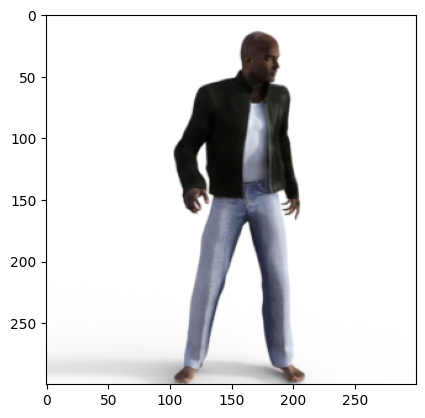

In [ ]:
test_image = np.array([test_images[np.random.randint(0, 100+1)]])
rgb_images = np.array(test_image)
rgb_image = rgb_images[0]
plt.imshow(rgb_image)

In [ ]:
result = model.predict(test_image)
predicted_value = np.argmax(result)

print("horse" if predicted_value == 0 else "human")


1/1 [==============================] - 0s 274ms/step
human


### A more comprehensive CNN

#### Adding Pooling Layers after each convolution

In [7]:
model = keras.Sequential([
  keras.layers.Conv2D(64, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Flatten(),
  keras.layers.Dense(2, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_images, train_labels, batch_size=32, epochs=10)

Epoch 1/10
33/33 [==============================] - 8s 218ms/step - loss: 0.9131 - accuracy: 0.7468
Epoch 2/10
33/33 [==============================] - 7s 227ms/step - loss: 0.1383 - accuracy: 0.9494
Epoch 3/10
33/33 [==============================] - 7s 220ms/step - loss: 0.0515 - accuracy: 0.9893
Epoch 4/10
33/33 [==============================] - 7s 218ms/step - loss: 0.0226 - accuracy: 0.9951
Epoch 5/10
33/33 [==============================] - 7s 216ms/step - loss: 0.0064 - accuracy: 0.9990
Epoch 6/10
33/33 [==============================] - 7s 215ms/step - loss: 0.0031 - accuracy: 1.0000
Epoch 7/10
33/33 [==============================] - 7s 217ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 8/10
33/33 [==============================] - 7s 213ms/step - loss: 7.8497e-04 - accuracy: 1.0000
Epoch 9/10
33/33 [==============================] - 7s 215ms/step - loss: 5.6157e-04 - accuracy: 1.0000
Epoch 10/10
33/33 [==============================] - 7s 216ms/step - loss: 4.6412e-04 - accu

In [8]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")

8/8 [==============================] - 1s 74ms/step - loss: 2.1643 - accuracy: 0.7500
Accuracy: 75.00% 


#### Adding Dropout

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(64, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Conv2D(32, 3, activation='relu'),
  keras.layers.MaxPool2D(2,2),
  keras.layers.Dropout(0.5),
  keras.layers.Flatten(),
  keras.layers.Dense(2, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_images, train_labels, batch_size=32, epochs=10)

Epoch 1/10
33/33 [==============================] - 8s 212ms/step - loss: 0.7802 - accuracy: 0.7585
Epoch 2/10
33/33 [==============================] - 7s 214ms/step - loss: 0.1015 - accuracy: 0.9679
Epoch 3/10
33/33 [==============================] - 7s 221ms/step - loss: 0.0535 - accuracy: 0.9786
Epoch 4/10
33/33 [==============================] - 7s 215ms/step - loss: 0.0237 - accuracy: 0.9922
Epoch 5/10
33/33 [==============================] - 7s 223ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 6/10
33/33 [==============================] - 7s 220ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 7/10
33/33 [==============================] - 7s 218ms/step - loss: 0.0013 - accuracy: 1.0000
Epoch 8/10
33/33 [==============================] - 7s 221ms/step - loss: 6.5286e-04 - accuracy: 1.0000
Epoch 9/10
33/33 [==============================] - 7s 218ms/step - loss: 6.2117e-04 - accuracy: 1.0000
Epoch 10/10
33/33 [==============================] - 7s 220ms/step - loss: 4.5782e-04 - accu

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")

8/8 [==============================] - 0s 27ms/step - loss: 316.9579 - accuracy: 0.8320
Accuracy: 83.20% 


#### Adding an intermediate Dense layer after the flattening

In [ ]:
model = keras.Sequential([
  keras.layers.Conv2D(32, 3, activation='relu'),
  # keras.layers.MaxPool2D(2,2),
  keras.layers.Conv2D(32, 3, activation='relu'),
  # keras.layers.MaxPool2D(2,2),
  # keras.layers.Dropout(0.5),
  keras.layers.Flatten(),
  # keras.layers.Dense(64, activation='relu'),
  keras.layers.Dense(2, activation='softmax')
])

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(train_images, train_labels, batch_size=32, epochs=10)

Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}% ")

### Hyperparameter Tuning using the Keras Tuner

#### Experimentation With The Number of Convolutional Layers And Their Size

In [9]:
# model = keras.Sequential([
#   keras.layers.Conv2D(64, 3, activation='relu'),
#   keras.layers.Conv2D(32, 3, activation='relu'),
#   keras.layers.Flatten(),
#   keras.layers.Dense(2, activation='softmax')
# ])

from keras import backend

def build_model(hp):
  backend.clear_session();
  model = keras.Sequential()

  for i in range(hp.Int("Conv2D layers", min_value=0, max_value=3)):
    model.add(keras.layers.Conv2D(hp.Choice(f"layer {i} filters", [16, 32, 64, 128]), 3, activation="relu"))

  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(2, activation="softmax"))

  model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

tuner = RandomSearch(build_model, objective="val_accuracy", max_trials=32, overwrite=True)
tuner.search(train_images, train_labels, validation_data=(test_images, test_labels), epochs=10, batch_size=32, callbacks=[stop_early])


Trial 32 Complete [00h 00m 47s]
val_accuracy: 0.7890625

Best val_accuracy So Far: 0.8984375
Total elapsed time: 00h 44m 40s


In [10]:
tuner.results_summary()
best_model = tuner.get_best_models()[0]

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
Conv2D layers: 3
layer 0 filters: 16
layer 1 filters: 32
layer 2 filters: 32
Score: 0.8984375
Trial summary
Hyperparameters:
Conv2D layers: 1
layer 0 filters: 64
layer 1 filters: 128
layer 2 filters: 32
Score: 0.8984375
Trial summary
Hyperparameters:
Conv2D layers: 1
layer 0 filters: 16
layer 1 filters: 32
layer 2 filters: 128
Score: 0.8984375
Trial summary
Hyperparameters:
Conv2D layers: 0
layer 0 filters: 128
layer 1 filters: 32
layer 2 filters: 64
Score: 0.88671875
Trial summary
Hyperparameters:
Conv2D layers: 2
layer 0 filters: 16
layer 1 filters: 32
layer 2 filters: 32
Score: 0.875
Trial summary
Hyperparameters:
Conv2D layers: 1
layer 0 filters: 128
layer 1 filters: 64
layer 2 filters: 128
Score: 0.859375
Trial summary
Hyperparameters:
Conv2D layers: 3
layer 0 filters: 64
layer 1 filters: 32
layer 2 filters: 16
Score: 0.859375
Trial summary
Hyperparameters:
Conv2D layers: 1
layer 0 

In [11]:
loss, accuracy = best_model.evaluate(test_images, test_labels)
print(f"Accuracy: {accuracy*100:.2f}%, Loss: {loss:.2f}")

8/8 [==============================] - 1s 82ms/step - loss: 0.3177 - accuracy: 0.8984
Accuracy: 89.84%, Loss: 0.32
